In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pydicom
from pydicom.data import get_testdata_file
# from mpl_toolkits.mplot3d import axes3d
import plotly.graph_objects as go
# import plotly

In [3]:
# Функция возращает значения mu(x,y) выбранной функции mu, для которой известно аналитическое решение p(ksi,theta)
def mu_func(x,y):
    global A_func
    global a_func
    global x0_func
    global y0_func
    global func_name

    if func_name == 0: #кольцо
        r2 = (x- x0_func)**2+(y-y0_func)**2
        return A_func*r2*np.exp(-r2/a_func**2)

    if func_name == 2: # точка
        return A_func*np.exp(-((x-x0_func)**2 + (y-y0_func)**2)/a_func**2)

    if func_name == 3: # диск
        ro = np.sqrt((x - x0_func)**2 + (y - y0_func)**2)
        if a_func - ro >=0.:
            return A_func
        else:
            return 0.
        
    if func_name == 4: # вогнутый парабаллоид с четкими границами
        ro = np.sqrt((x - x0_func)**2 + (y - y0_func)**2)
        if a_func - ro >=0.:
            return A_func*ro**2
        else:
            return 0.

# Функция формирует массив mu заданного размера по известной аналитической функции
def mu_func_array():
    global N_xy
    mu = np.zeros((N_xy,N_xy))
    for int_x in range(N_xy):
        for int_y in range(N_xy):
            mu[int_x, int_y] = mu_func(int_to_xy(int_x),int_to_xy(int_y))

    return mu

# Функция возращает значения p(ksi,theta) выбранной функции p, для которой известно аналитическое решение mu(x,y)
def p_func(ksi, theta):
    global A_func
    global a_func
    global x0_func
    global y0_func
    global func_name
    ksi_ = ksi - x0_func*np.cos(theta) - y0_func*np.sin(theta)
    if func_name == 0:
        if ksi_ == 0:
            return 0.8862269254527578
        return np.sqrt(np.pi)*A_func*a_func*ksi_**2*np.exp(-ksi_**2/a_func**2)*(a_func**2/2/ksi_**2+1)
    if func_name == 2:
        return np.sqrt(np.pi)*A_func*a_func*np.exp(-ksi_**2/a_func**2)

    if func_name == 3:
        if a_func >= np.abs(ksi_):
            return 2*A_func*np.abs(ksi_)*np.sqrt((a_func/ksi_)**2-1)
        else:
            return 0.
        
    if func_name == 4: # эта функция пока не решена аналитически
        if a_func >= np.abs(ksi_):
            return 2*A_func*np.abs(ksi_)*np.sqrt((a_func/ksi_)**2-1)
        else:
            return 0.


# Функция формирует массив p заданного размера по известной аналитической функции
def p_func_array():
    global N_angels
    global N_rays
    p = np.zeros((N_rays,N_angels))
    for int_theta in range(N_angels):
        for int_ksi in range(N_rays):
            p[int_ksi, int_theta] = p_func(int_to_ksi(int_ksi),int_to_theta(int_theta))

    return p

In [4]:
# Набор функций для перевода значений переменных из реальных значений в индексы и обратно
def theta_to_int(theta):
    global N_angels
    return int(theta/2/np.pi*N_angels)

def ksi_to_int(ksi):
    global xy_max
    global rays_d
    return int((ksi + np.sqrt(2)*xy_max)/rays_d)

def xy_to_int(xy):
    global N_xy
    global xy_max
    return int((xy + xy_max)/2/xy_max*N_xy)

def int_to_theta(i):
    global N_angels
    return i*2.*np.pi/N_angels

def int_to_ksi(i):
    global xy_max
    global rays_d
    return i*rays_d - np.sqrt(2)*xy_max

def int_to_xy(i):
    global N_xy
    global xy_max
    return 2*xy_max/N_xy*i - xy_max

In [5]:
def sinc(x):
    if x == 0:
        return 1
    return np.sin(x)/x

def h1(ksi):
    # xi0 = 0.1
    global xi0
    return xi0**2/np.pi/2*(sinc(xi0*ksi) - (sinc(xi0*ksi/2))**2/2.)


def p_convolution(p:np.array): #функция, возвращающая одномерную свертку двумерной функции
    global N_rays
    global N_angels
    global rays_d # dksi при численном интегрировании
    f = np.zeros((N_rays,N_angels))
    for int_ksi in range(N_rays):
        for int_theta in range(N_angels):
            integral_1_47 = 0
            for int_ksi0 in range(N_rays):
                ksi_minus_ksi0 = int_to_ksi(int_ksi-int_ksi0)
                integral_1_47+=p[int_ksi0,int_theta]*h1(ksi_minus_ksi0)
            f[int_ksi,int_theta] = integral_1_47*rays_d

    return f

def One_dimentional_filtration_method(p:np.array):
    global N_xy
    global N_angels
    
    f = p_convolution(p)

    mu_evalv = np.zeros((N_xy,N_xy))
    for int_x in range(N_xy):
        for int_y in range(N_xy):
            integral_1_49 = 0
            for int_theta in range(N_angels):
                x = int_to_xy(int_x)
                y = int_to_xy(int_y)
                theta = int_to_theta(int_theta)
                ksi = x*np.cos(theta) + y*np.sin(theta)
                # int_ksi = ksi_to_int(ksi)
                # if -N_rays <= int_ksi < N_rays:
                integral_1_49+=f[ksi_to_int(ksi),int_theta]
            mu_evalv[int_x, int_y] = integral_1_49/N_angels # вообще должно быть *dtheta/2/np.pi, но dtheta = 2*np.pi/N_angels

    return mu_evalv

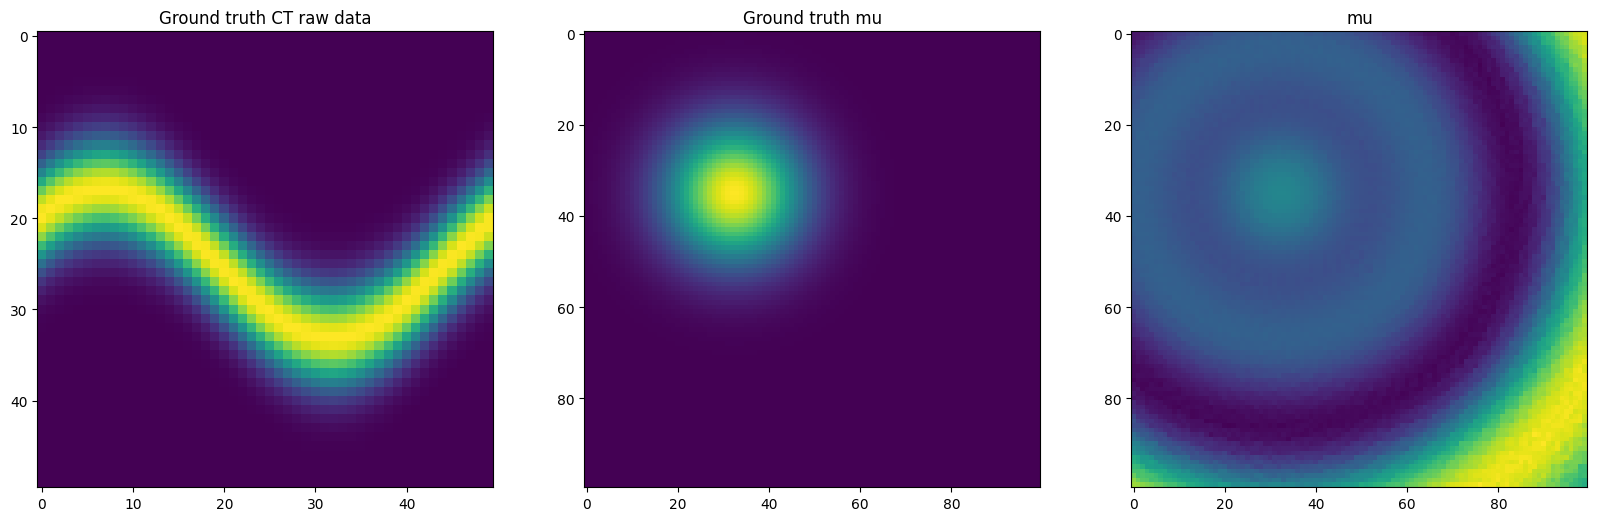

<Figure size 2000x200 with 0 Axes>

In [7]:
N_angels = 50 # количество углов вращения
N_rays = 50 # количество лучей в пучке (картинку будет адевать только около половины лучей в среднем за один угол)
N_xy = 100 # размер сетки в единицах имерения количества штук клеток. Оптимально - чтобы совпадало с рарешением пикселей картинки
xy_max = 100 # размер сетки в сантиметрах. Стоит учесть, что в сантиметрах система координат в центре, а в пиксилях - в углу
rays_d = np.sqrt(2)*2*xy_max/N_rays # расстояние между лучами

A_func = 1
a_func = 30
x0_func = -30
y0_func = -35
func_name = 2
p = p_func_array()
mu = mu_func_array()

xi0 = 0.1#np.pi/rays_d
mu_reconstructed =  One_dimentional_filtration_method(p)



fig, ax = plt.subplots(1,3, figsize = (20,20))
plt.figure(figsize = (20,2))

ax[0].imshow(p)
ax[0].set_title('Ground truth CT raw data')

ax[1].imshow(mu)
ax[1].set_title('Ground truth mu')

ax[2].imshow(mu_reconstructed)
ax[2].set_title('mu')

plt.show()

In [8]:
mu3D = go.Surface(z=mu_reconstructed, x=np.asarray(range(N_xy)), y=np.asarray(range(N_xy)))

fig = go.Figure(data = [mu3D])
fig.update_layout(title='mu')
fig.show()